In [1]:
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import hist
import hist.dask as hda
import dask
import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import vector

NanoAODSchema.warn_missing_crossrefs = False

/usr/local/lib/python3.12/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
# Datasets:
#/BulkGravToWW_narrow_M-*_13TeV-madgraph/*NanoAODv7*/NANOAODSIM
#/RSGravToWWToWlepWhad_width0p1_M-*_TuneCUETP8M1_13TeV-madgraph-pythia8/*NanoAODv3*/NANOAODSIM


# When having a large number of files it is useful to put the list on a separate file.
# import json

# with open("semileptonic_notebooks/samples.json", 'r') as sample_file:
#     fileset = json.load(sample_file)

# for sample in fileset:
#     print(sample)

# For now we are only testing on a limited number of files so they are just listed here
fileset = {
    'BulkGravToWW': {
        'files': {
            'root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv7/BulkGravToWW_narrow_M-1000_13TeV-madgraph/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/100000/D4404DCB-FBF8-C640-87B0-2DA1D5139083.root': "Events",
        },
        'metadata': {
            'is_mc': 'Events',
        },
    },
    'RSGravToWW': {
        'files': {
            'root://cmsxrootd.fnal.gov//store/mc/RunIISummer16NanoAODv3/RSGravToWWToWlepWhad_width0p1_M-1200_TuneCUETP8M1_13TeV-madgraph-pythia8/NANOAODSIM/PUMoriond17_94X_mcRun2_asymptotic_v3-v1/60000/4442437A-52BB-E811-A8DA-90E2BACC5EEC.root': "Events",
          },
        'metadata': {
            'is_mc': 'Events',
        },
    }
}

In [3]:
# This step takes some time because it is loading the events
test_dataset = 'BulkGravToWW'
events = NanoEventsFactory.from_root(
    fileset[test_dataset]['files'],
    entry_stop = 1000, # this limit the number of events, good to experiment more quickly
    metadata = fileset[test_dataset]['metadata'],
    schemaclass = NanoAODSchema,
    delayed=False,
).events()

In [4]:
# This code was written by David https://github.com/wbuitrago/Scripts_HadronicVBS/blob/main/Costheta.py
def get_w_decay_quark_pairs_gen(events):
    """
    Extraction of pairs of quarks coming from a W boson at generator level
    Gave a 'vector.Momentum4D'.
    """
    if events is None or len(events) == 0:
        return []
        
    pdgId = events.GenPart.pdgId
    mothers = events.GenPart.genPartIdxMother
    
    all_quark_pairs_vectors = []

    print(f"[INFO] Processing events to find W -> qq'.")
    num_w_decay_to_quarks = 0
    for i in range(len(events)): 
        event_pdgId = pdgId[i]
        event_mothers = mothers[i]
        
        # Label of the W boson in the actual event
        # abs(pdgId) == 24 for W+ and W-
        w_indices_in_event = ak.local_index(event_pdgId)[abs(event_pdgId) == 24]

        for w_idx in w_indices_in_event:
            # Indexes for the quarks doughters coming from to the W (abs(pdgId) between 1 and 6)
            daughter_indices = ak.local_index(event_pdgId)[
                (event_mothers == w_idx) & (abs(event_pdgId) >= 1) & (abs(event_pdgId) <= 6)
            ]
            
            if len(daughter_indices) == 2:
                num_w_decay_to_quarks += 1
                q1_data = {
                    "pt": events.GenPart.pt[i][daughter_indices[0]],
                    "eta": events.GenPart.eta[i][daughter_indices[0]],
                    "phi": events.GenPart.phi[i][daughter_indices[0]],
                    "mass": events.GenPart.mass[i][daughter_indices[0]],
                }
                q2_data = {
                    "pt": events.GenPart.pt[i][daughter_indices[1]],
                    "eta": events.GenPart.eta[i][daughter_indices[1]],
                    "phi": events.GenPart.phi[i][daughter_indices[1]],
                    "mass": events.GenPart.mass[i][daughter_indices[1]],
                }
                q1_vec = vector.obj(pt=q1_data["pt"], eta=q1_data["eta"], phi=q1_data["phi"], mass=q1_data["mass"])
                q2_vec = vector.obj(pt=q2_data["pt"], eta=q2_data["eta"], phi=q2_data["phi"], mass=q2_data["mass"])
                all_quark_pairs_vectors.append([q1_vec, q2_vec])
                
    print(f"[INFO] Found {len(all_quark_pairs_vectors)} pairs of quarks {num_w_decay_to_quarks} for W->qq'.")
    return all_quark_pairs_vectors


In [5]:
w_decay_quark_pairs_gen = get_w_decay_quark_pairs_gen(events)

[INFO] Processing events to find W -> qq'.
[INFO] Found 1335 pairs of quarks 1335 for W->qq'.


<class 'list'>


In [6]:
# This code was written by David https://github.com/wbuitrago/Scripts_HadronicVBS/blob/main/Costheta.py
def calculate_cos_theta_star_gen(quark_pairs_vectors):
    """
    Computation cos(theta*) for the list of pair of quarks.
    theta* is the angle betweeen the quark direction (in the W rest frame) and the dirección of W (in the lab frame).
    """
    cos_theta_stars = []

    if not quark_pairs_vectors:
        print(f"[WARN] Quark pairs not loaded for computation of cos(theta*).")
        return np.array([])
    print(len(quark_pairs_vectors))
    for q_pair in quark_pairs_vectors:
        q1 = q_pair[0] 
        q2 = q_pair[1]
        w_lab = q1 + q2 
        if w_lab.mass < 1e-3 or w_lab.E <= 1e-6:
            print("1")
            continue 

        beta3 = w_lab.to_beta3()
        q1_in_w_rest = q1.boost_beta3(-beta3)
        
        # Axis z' in the helicity frame
        w_direction_lab_3vec = w_lab.to_beta3() 

        if w_direction_lab_3vec.mag < 1e-6:
            continue 
        
        q1_direction_w_rest_3vec = q1_in_w_rest.to_beta3()
        
        if q1_direction_w_rest_3vec.mag < 1e-6: 
            continue

        cos_theta = q1_direction_w_rest_3vec.unit().dot(w_direction_lab_3vec.unit())
        cos_theta_stars.append(cos_theta)
        
    print(f"[INFO] Computed {len(cos_theta_stars)} values of cos(theta*).")
    return np.array(cos_theta_stars)

In [7]:
cos_theta_star_gen = calculate_cos_theta_star_gen(w_decay_quark_pairs_gen)
print(cos_theta_star_gen)

1335
[INFO] Computed 1335 values of cos(theta*).
[-0.68291903 -0.23322115  0.22334667 ... -0.34365172  0.73052278
  0.51133234]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9f34d2c4a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

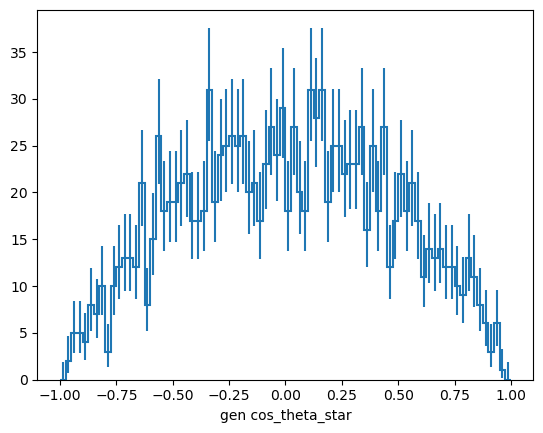

In [8]:
gen_cos_theta_star_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="BG", categories=[], growth=True),
                            hist.axis.Regular(name='gen_AK8_cos_theta_star', label='gen cos_theta_star', bins=80, start=-1, stop=1))
gen_cos_theta_star_hist.fill(dataset=test_dataset, gen_AK8_cos_theta_star=cos_theta_star_gen)
gen_cos_theta_star_hist.plot1d()


In [9]:
# Can you now try to plot the same variable for the RSgraviton?

In [10]:
# Can you plot them on the same figure?

In [11]:
# When you are happy with the result, go back to the beginning and add more files with different resonance mass

In [18]:
def get_w_quark_pairs(events):
    pdgId = events.GenPart.pdgId
    mothers = events.GenPart.genPartIdxMother

    is_w = abs(pdgId) == 24
    is_quark = (abs(pdgId) <= 6) # Quarks u,d,s,c,b,t

    w_indices = ak.local_index(pdgId)[is_w]
    quark_indices = ak.local_index(pdgId)[is_quark]
    quark_parents = mothers[is_quark]

    w_quark_map = {} # (event_index, w_boson_index_in_event) -> [quark1_index_in_event, quark2_index_in_event]

    for evt_idx in range(len(pdgId)):
        # W's in the specific event
        event_w_indices = w_indices[evt_idx]
        # Quarks in the event
        event_quark_indices = quark_indices[evt_idx]
        event_quark_parents = quark_parents[evt_idx]
        
        for w_idx_in_event in event_w_indices:
            # Find quarks coming from W's Parent 
            daughter_quarks_indices_in_event = event_quark_indices[event_quark_parents == w_idx_in_event]
            if len(daughter_quarks_indices_in_event) == 2:
                w_quark_map[(evt_idx, w_idx_in_event)] = daughter_quarks_indices_in_event
    return w_quark_map

In [104]:
# Matching GenJetAK8 and FatJet with the quark pairs coming from the W decay
def match_w_to_fatjets(events, w_quark_map):
     # Prepare containers for each event (same length as events)
    matched_fatjets_per_event = [[] for _ in range(len(events))]

    genjets = ak.zip({
        "pt": events.GenJetAK8.pt, "eta": events.GenJetAK8.eta,
        "phi": events.GenJetAK8.phi, "mass": events.GenJetAK8.mass
    }, with_name="Momentum4D")

    fatjets = ak.zip({
        "pt": events.FatJet.pt, "eta": events.FatJet.eta,
        "phi": events.FatJet.phi, "mass": events.FatJet.mass,
        "msoftdrop": events.FatJet.msoftdrop,
        "tau1": events.FatJet.tau1, "tau2": events.FatJet.tau2,
        "genJetIdx": events.FatJet.genJetAK8Idx,
        "subJetIdx1": events.FatJet.subJetIdx1,
        "subJetIdx2": events.FatJet.subJetIdx2
    })

    genparts = ak.zip({
        "pt": events.GenPart.pt, "eta": events.GenPart.eta,
        "phi": events.GenPart.phi, "mass": events.GenPart.mass
    }, with_name="Momentum4D")

    for (evt_idx, w_gen_idx), quark_gen_indices in w_quark_map.items():
        q1_gen_idx = quark_gen_indices[0]
        q2_gen_idx = quark_gen_indices[1]

        # Building quarks 4-vector 
        q1 = genparts[evt_idx][q1_gen_idx]
        q2 = genparts[evt_idx][q2_gen_idx]
        
        # Iteration in GenJetAK8 in the event - evt_idx
        for gj_local_idx, gj in enumerate(genjets[evt_idx]):
            if gj.deltaR(q1) < 0.8 and gj.deltaR(q2) < 0.8:
                
                # Mask for the FatJets in the actual event that is matching with gj_local_idx
                matching_fj_mask = (events.FatJet.genJetAK8Idx[evt_idx] == gj_local_idx)
                matched_fjs = events.FatJet[evt_idx][matching_fj_mask]
                
                
                if len(matched_fjs) > 0:
                    matched_fatjets_per_event[evt_idx].append(matched_fjs[0])
                    break

    # Convert list-of-lists of records back into ak.Array
    return ak.Array(matched_fatjets_per_event)

<class 'list'>
<class 'awkward.highlevel.Array'>
['area', 'btagCMVA', 'btagCSVV2', 'btagDDBvL', 'btagDDBvL_noMD', 'btagDDCvB', 'btagDDCvB_noMD', 'btagDDCvL', 'btagDDCvL_noMD', 'btagDeepB', 'btagHbb', 'deepTagMD_H4qvsQCD', 'deepTagMD_HbbvsQCD', 'deepTagMD_TvsQCD', 'deepTagMD_WvsQCD', 'deepTagMD_ZHbbvsQCD', 'deepTagMD_ZHccvsQCD', 'deepTagMD_ZbbvsQCD', 'deepTagMD_ZvsQCD', 'deepTagMD_bbvsLight', 'deepTagMD_ccvsLight', 'deepTag_H', 'deepTag_QCD', 'deepTag_QCDothers', 'deepTag_TvsQCD', 'deepTag_WvsQCD', 'deepTag_ZvsQCD', 'eta', 'mass', 'msoftdrop', 'n2b1', 'n3b1', 'phi', 'pt', 'rawFactor', 'tau1', 'tau2', 'tau3', 'tau4', 'lsf3', 'jetId', 'subJetIdx1', 'subJetIdx2', 'electronIdx3SJ', 'muonIdx3SJ', 'genJetAK8Idx', 'hadronFlavour', 'nBHadrons', 'nCHadrons', 'genJetAK8IdxG', 'subJetIdx1G', 'subJetIdx2G', 'subJetIdxG']
<class 'awkward.highlevel.Array'>
1000 * var * float64
[[], [105], [], [92.6, 107], [87.2]]
[105, 92.6, 107, 87.2]


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f9f0781b380>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

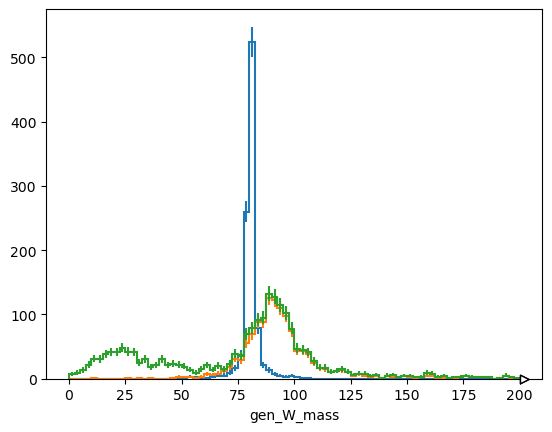

In [112]:
gen_W = events.GenPart[abs(events.GenPart.pdgId)==24]
gen_W_single = gen_W[:, 0] # first of the two Ws

w_quark_map = get_w_quark_pairs(events)
jet_W = match_w_to_fatjets(events, w_quark_map)
print(type(jet_W))
print(ak.type(jet_W.mass))
print(jet_W.mass[:5])# Print first 5 entries
print(ak.flatten(jet_W.mass[:5]))
gen_W_mass_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="GenPart", categories=[], growth=True),
                            hist.axis.Regular(name='gen_W_mass', label='gen_W_mass', bins=80, start=0, stop=200))
gen_W_mass_hist.fill(dataset=test_dataset, gen_W_mass=gen_W_single.mass)
gen_W_mass_hist.plot1d(label="GenW")
jet_W_mass_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="MatchedJet", categories=[], growth=True),
                            hist.axis.Regular(name='jet_W_mass', label='jet_W_mass', bins=80, start=0, stop=200))
jet_W_mass_hist.fill(dataset=test_dataset, jet_W_mass=ak.flatten(jet_W.mass))
jet_W_mass_hist.plot1d(label="MatchedJet")

fatjet_mass_hist = hist.Hist(hist.axis.StrCategory(name='dataset', label="FatJet", categories=[], growth=True),
                            hist.axis.Regular(name='jet_W_mass', label='jet_W_mass', bins=80, start=0, stop=200))
fatjet_mass_hist.fill(dataset=test_dataset, jet_W_mass=ak.flatten(events.FatJet.mass))
fatjet_mass_hist.plot1d(label="FatJet")



<class 'list'>
<class 'awkward.highlevel.Array'>
['area', 'btagCMVA', 'btagCSVV2', 'btagDDBvL', 'btagDDBvL_noMD', 'btagDDCvB', 'btagDDCvB_noMD', 'btagDDCvL', 'btagDDCvL_noMD', 'btagDeepB', 'btagHbb', 'deepTagMD_H4qvsQCD', 'deepTagMD_HbbvsQCD', 'deepTagMD_TvsQCD', 'deepTagMD_WvsQCD', 'deepTagMD_ZHbbvsQCD', 'deepTagMD_ZHccvsQCD', 'deepTagMD_ZbbvsQCD', 'deepTagMD_ZvsQCD', 'deepTagMD_bbvsLight', 'deepTagMD_ccvsLight', 'deepTag_H', 'deepTag_QCD', 'deepTag_QCDothers', 'deepTag_TvsQCD', 'deepTag_WvsQCD', 'deepTag_ZvsQCD', 'eta', 'mass', 'msoftdrop', 'n2b1', 'n3b1', 'phi', 'pt', 'rawFactor', 'tau1', 'tau2', 'tau3', 'tau4', 'lsf3', 'jetId', 'subJetIdx1', 'subJetIdx2', 'electronIdx3SJ', 'muonIdx3SJ', 'genJetAK8Idx', 'hadronFlavour', 'nBHadrons', 'nCHadrons', 'genJetAK8IdxG', 'subJetIdx1G', 'subJetIdx2G', 'subJetIdxG']


1000
1000


IndexError: cannot slice RegularArray (of length 1) with [[], [0], [], [2, 0], [0], [0], ..., [0, ...], [0], [0, 2], [], [0, 2], [2, 0]]: cannot fit jagged slice with length 1000 into RegularArray of size 1